In [38]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
#Using newest versions of all libraries

In [39]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

# Predict using resnet

This notebook uses a saved resnet model to predict on test data and generate a confusion matrix. It also saves the wrong predictions for further analysis.

In [40]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT=True

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{TEST_N_EVENTS}_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

MODEL_NAME = "resnet_1696846798_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT_res50"
LOAD_FOLDER = "../results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")
DEVICE = torch.device("cpu")
ampl.use_atlas_style() 

Running on the GPU


In [41]:
#import model
model = ResNet18(img_channels=3, num_classes=6)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)
print("Loading model")

Loading model


In [42]:
#Load data
testpaths = [Path(path) for path in TEST_DATAPATHS]
print(testpaths)

test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)
eventids = test_data.getids().flatten()
if len(eventids) != len(test_data):
    print("Error in lengths of arrays")

[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_test_res50_STmin7_Nmin5_15000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_STmin7_Nmin5_15000_events.h5')]
Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2

In [43]:
truth, preds, confidences = predict(model, test_data, CLASSES, 100, RES, DEVICE, return_values=True)
df = pd.DataFrame(dict(zip(["Truth", "Prediction"], [truth, preds])))
df["EventID"] = eventids
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 900/900 [01:36<00:00,  9.35it/s]


[93.06  2.86  2.81  0.31  0.74  0.22 16.53 10.73 57.55  4.59  3.27  7.33
 12.42 40.48 12.67  7.87 11.72 14.83  7.47 30.15 14.77 10.53 12.79 24.28
  5.99 26.58 16.24  9.87 12.78 28.54  1.95  7.67  3.51  1.19 79.87  5.81]


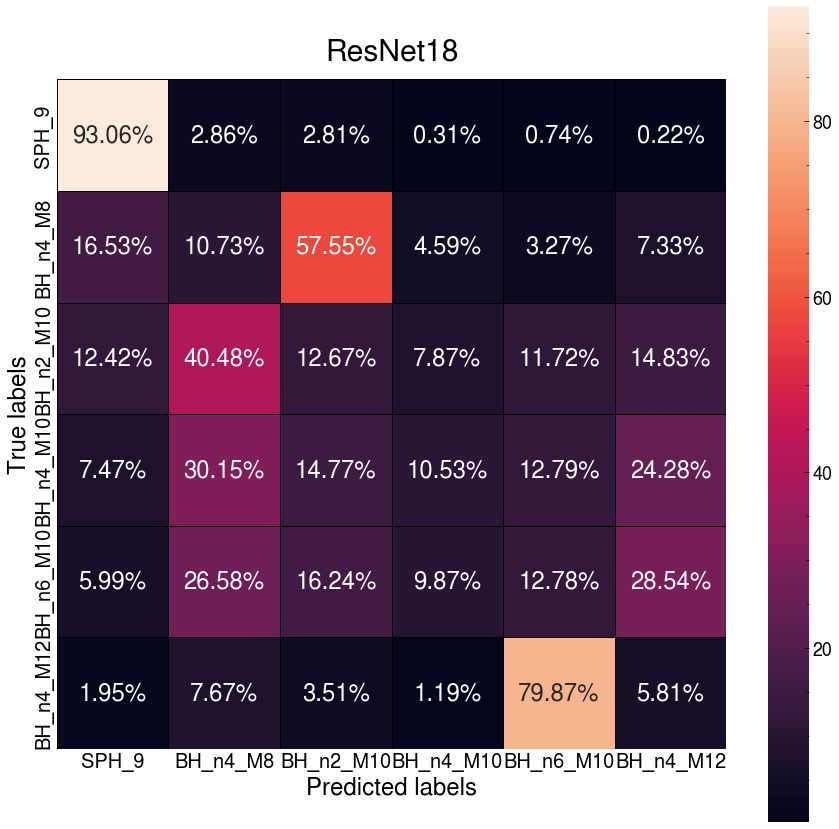

In [44]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(15, 15))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Prediction"], normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={'format':f'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18", size=30, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(df, accuracy, PLOT_LABELS)

In [45]:
df_wrong = df[df["Prediction"] != df["Truth"]]

In [46]:
#Look at the confidences
for i in range(len(LABELS)):
    temp = df[df["Truth"]==i]
    temp_len = len(temp)
    print(f"Predictions on truth {temp_len} {LABELS[i]} events:")
    for j in range(len(LABELS)):
        preds = temp[temp["Prediction"]==j]
        print(f"{len(preds)} events predicted as {LABELS[j]}")
        print(f"Average confidence: {preds[LABELS[j]].mean()}, Std: {preds[LABELS[j]].std()}")
    print("----")



Predictions on truth 15000 PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL events:
13959 events predicted as PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL


KeyError: 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL'

In [ ]:
test = df[df["Truth"]==0]
print(test[test["Prediction"]==4])

      Truth  Prediction  EventID  PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL  \
305     0.0         4.0     6583                                0.007675   
307     0.0         4.0     6597                                0.034350   
373     0.0         4.0     6902                                0.275958   
375     0.0         4.0     6906                                0.008457   
419     0.0         4.0     7142                                0.187634   
428     0.0         4.0     7207                                0.302351   
498     0.0         4.0     7558                                0.389955   
728     0.0         4.0     8758                                0.268484   
944     0.0         4.0     9726                                0.000835   
1068    0.0         4.0     1040                                0.183894   
1087    0.0         4.0    10501                                0.013871   
1088    0.0         4.0    10502                                0.146032   
1117    0.0 

In [ ]:
print(df[df["Truth"]==1])

      Truth  Prediction  EventID  PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL  \
3000    1.0         1.0        1                                0.000263   
3001    1.0         5.0        6                                0.000001   
3002    1.0         1.0       22                                0.000036   
3003    1.0         4.0      153                                0.000081   
3004    1.0         1.0     1505                                0.295389   
...     ...         ...      ...                                     ...   
5995    1.0         2.0     1498                                0.026515   
5996    1.0         4.0     1499                                0.102610   
5997    1.0         4.0     1500                                0.000236   
5998    1.0         1.0     1502                                0.000404   
5999    1.0         0.0     1504                                0.582888   

      BH_n2_M10  BH_n4_M8  BH_n4_M10  BH_n4_M12  BH_n6_M10  
3000   0.305048  0.107291 

In [ ]:
#Reliability diagram


In [ ]:
def save_wrong_predictions(truths, labels, eventids, savepath, filename):
    file = open(f"{savepath}/{filename}.csv", "w")
    file.write(f"Wrongly predicted events from datasets: {testpaths} by model {MODEL_NAME}")
    for i, truth in enumerate(truths):
        file.write(f"{labels[int(truth)]}, {eventids[i]}\n")
    file.close()
    print(f"Saved results to {savepath}/{filename}.csv")
    
filename = f"{MODEL_NAME}_{TEST_N_EVENTS}_events_wrongly_predicted"
save_wrong_predictions(df_wrong["Truth"].tolist(), PLOT_LABELS, df_wrong["EventID"].tolist(), "../results/", filename)